
### clean = 0
### hate = 1

In [1]:
import numpy as np
import pandas as pd
import string
import seaborn as sns
import re
import pickle
import nltk


from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
lemma = WordNetLemmatizer()
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=3000)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

pd.set_option("display.max_colwidth", None)

In [2]:
df = pd.read_csv('labeled_data.csv')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [3]:
df.shape

(24783, 7)

In [4]:
# 1. Data cleaning
# 2. EDA
# 3. Text Preprocessing
# 4. Model building
# 5. Evaluation
 

## 1. Data Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [6]:
# drop extra col
df = df[['class','tweet']]
df.sample(5)

,class,tweet
3253,1,@GforGent bitch what happen to comin thru
4366,1,"@OurCofE An end to the ordination of women and faggots, whose only aim is to weaken and split our communion."
21648,1,Them hoes gone be called strvp
1970,2,&#9733; BEST ASIAN MASSAGE ON THE Brooklyn Park slope --TOP RATED SPA &#9733;718-622-0221 - 24 http://t.co/yRfdaIooYZ
20558,1,Rule number one never pursue a bitch from da ova side


In [7]:
# missing values
df.isnull().sum()

class    0
tweet    0
dtype: int64

In [8]:
# check for duplicate values
df.duplicated().sum()

0

In [9]:
def class_clean_hate(x):
    if x==2:
        return 0
    else:
        return 1

In [10]:
df['class'] = df['class'].apply(lambda x: class_clean_hate(x))
df.head()

,class,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


## 2.EDA

In [11]:
df['class'].value_counts()

1    20620
0     4163
Name: class, dtype: int64

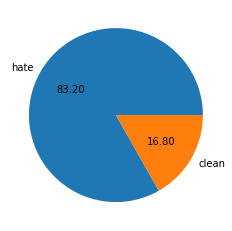

In [12]:
import matplotlib.pyplot as plt
plt.pie(df['class'].value_counts(), labels=['hate','clean'],autopct="%0.2f")
plt.show()

In [13]:
# Data is imbalanced

## 3. Data Preprocessing
- remove Email, mention, RT, URL
- Lower case
- Tokenization
- Removing special characters
- Removing stop words and punctuation
- Lemmatization

In [14]:
def text_preProcessing(tweet):
    
    tweet = re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)','',tweet) # remove Email
    tweet = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?','', tweet) # remove URL
    tweet = " ".join(word for word in tweet.split() if not word.startswith(('#','@'))) # mention
    tweet = tweet.lower() # Lower case
    tweet = re.sub('rt','',tweet) # remove RT
    tweet = re.sub('[^A-Z a-z-_]+','',tweet) # except alphanumeric
    tweet = " ".join(tweet.split()) # multiple spaces
    tweet = " ".join(word for word in tweet.split() if word not in stopwords.words('english')) # remove stopword
    tweet = " ".join(word for word in tweet.split() if word not in string.punctuation) # remove punctuation
    tweet = " ".join(lemma.lemmatize(word, wordnet.VERB) for word in tweet.split()) # lemmatization verb
            
    return "".join(tweet)

In [15]:
# x = 'Hi, email me at arafat6462@gmail.com, you can also find me on 18-37576-1@student.aiub.edu'
# x = 'hi, visit https://youtube.com/arafat6462 https://youtube.com mmm'
# x = '!!! RT @mayasolovely:   Hello    @#$ab123c+_-*/(`? '
# x = """ "\n15 " broke bitch cant tell me nothing "\n21  """
# x = "i me m my 9 ( ) @# hello my name is Arafat "
# x = "mi names is Araf@t i love #runninng rocks goood corpora @publishar"
# x = "@Arafat hossain #sover"

# text_preProcessing(x)

In [16]:
df['clean_tweet'] = df['tweet'].apply(text_preProcessing)
df.head()

,class,tweet,clean_tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...,woman shouldnt complain clean house amp man always take trash
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,boy dats coldtyga dwn bad cuffin dat hoe st place
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit,dawg ever fuck bitch sta cry confuse shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,look like tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;,shit hear might true might faker bitch tell ya


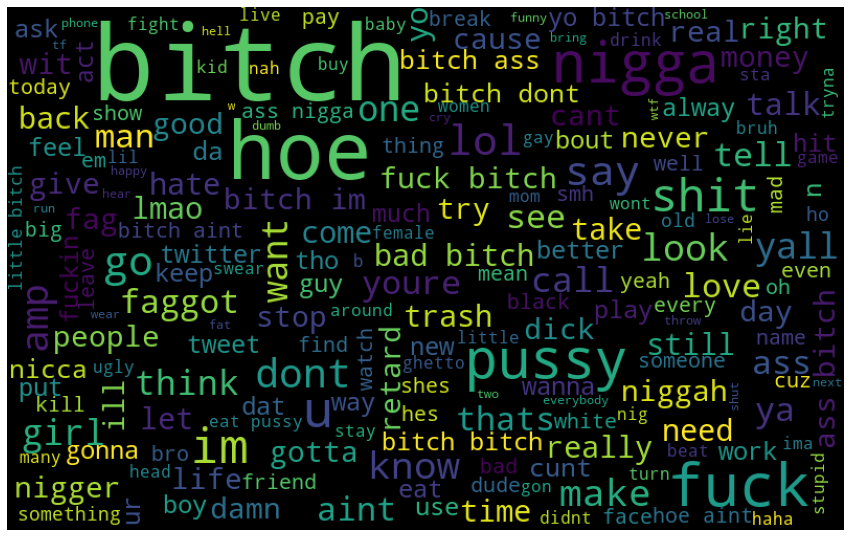

In [17]:
wc = WordCloud(width=800,height=500,max_font_size=100,random_state=42)
hate_wc = wc.generate(df[df['class'] == 1]['clean_tweet'].str.cat(sep=" "))
plt.figure(figsize=(15,10))
plt.imshow(hate_wc)
plt.axis('off')
plt.show()

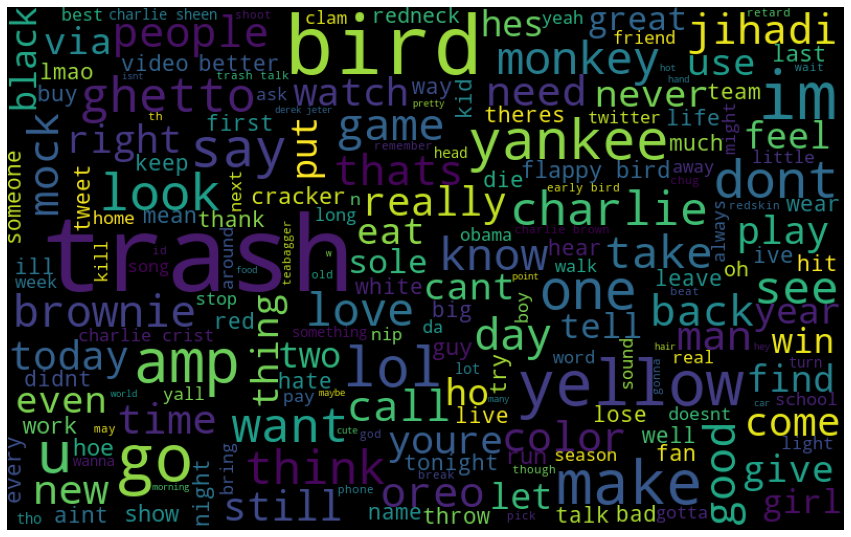

In [18]:
clean_wc = wc.generate(df[df['class'] == 0]['clean_tweet'].str.cat(sep=" "))
plt.figure(figsize=(15,10))
plt.imshow(clean_wc)
plt.axis('off')
plt.show()

In [19]:
hate_corpus = []
for tweet in df[df['class'] == 1]['clean_tweet'].tolist():
    for word in tweet.split():
        hate_corpus.append(word)
        

In [20]:
len(hate_corpus)

155976

/home/arafat/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


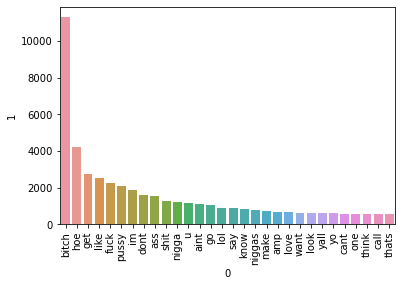

In [21]:
from collections import Counter
sns.barplot(pd.DataFrame(Counter(hate_corpus).most_common(30))[0],pd.DataFrame(Counter(hate_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [22]:
clean_corpus = []
for tweet in df[df['class'] == 0]['clean_tweet'].tolist():
    for word in tweet.split():
        clean_corpus.append(word)

In [23]:
len(clean_corpus)

33183

/home/arafat/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


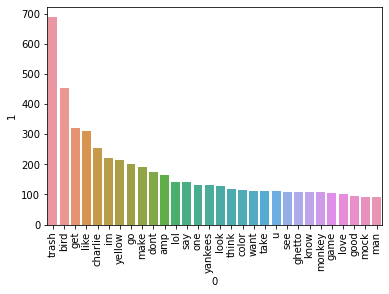

In [24]:
sns.barplot(pd.DataFrame(Counter(clean_corpus).most_common(30))[0],pd.DataFrame(Counter(clean_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

## 4. Model Building

In [25]:
X = tfidf.fit_transform(df['clean_tweet']).toarray()
y = df['class'].values
X.shape

(24783, 3000)

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [27]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
 

In [28]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'GNB': gnb, 
    'MNB': mnb, 
    'BNB': bnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt
 
}

In [29]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [30]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9469437159572321
Precision -  0.9724409448818898
For  KN
Accuracy -  0.6695582005245108
Precision -  0.8954122553737568
For  GNB
Accuracy -  0.5261246721807545
Precision -  0.938938938938939
For  MNB
Accuracy -  0.8890457938269114
Precision -  0.8869527336092354
For  BNB
Accuracy -  0.9344361508977204
Precision -  0.958495145631068
For  DT
Accuracy -  0.8432519669154731
Precision -  0.9964179104477612
For  LR
Accuracy -  0.9493645350010087
Precision -  0.983433734939759
For  RF
Accuracy -  0.9481541254791205
Precision -  0.9717860647693818
For  AdaBoost
Accuracy -  0.9376639096227557
Precision -  0.9851662404092072
For  BgC
Accuracy -  0.9467419810369175
Precision -  0.9754768392370572
For  ETC
Accuracy -  0.9412951381884204
Precision -  0.9669279764821166
For  GBDT
Accuracy -  0.8959047811176114
Precision -  0.9014998880680546


In [31]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Accuracy',ascending=False)
performance_df

,Algorithm,Accuracy,Precision
6,LR,0.949365,0.983434
7,RF,0.948154,0.971786
0,SVC,0.946944,0.972441
9,BgC,0.946742,0.975477
10,ETC,0.941295,0.966928
8,AdaBoost,0.937664,0.985166
4,BNB,0.934436,0.958495
11,GBDT,0.895905,0.901500
3,MNB,0.889046,0.886953
5,DT,0.843252,0.996418


In [32]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")
performance_df1

,Algorithm,variable,value
0,LR,Accuracy,0.949365
1,RF,Accuracy,0.948154
2,SVC,Accuracy,0.946944
3,BgC,Accuracy,0.946742
4,ETC,Accuracy,0.941295
5,AdaBoost,Accuracy,0.937664
6,BNB,Accuracy,0.934436
7,GBDT,Accuracy,0.895905
8,MNB,Accuracy,0.889046
9,DT,Accuracy,0.843252


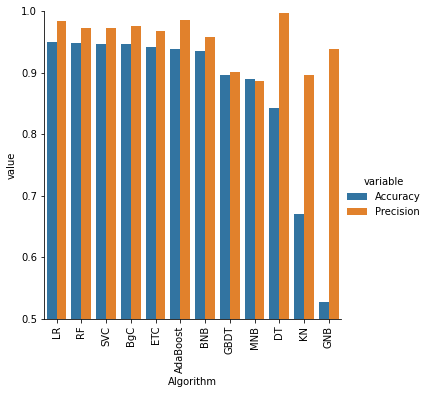

In [33]:
sns.catplot(x = 'Algorithm', y='value',hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

In [37]:

pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(lrc,open('model.pkl','wb'))

In [38]:
tf = pickle.load(open('vectorizer.pkl','rb'))
model = pickle.load(open('model.pkl','rb'))

In [40]:
x = "woman shouldnt complain clean house amp man always take trash"
# x = "we dont trust these niggas"

v_in = tf.transform([x]) # vectorize
result = model.predict(v_in) # predict
if result == 0:
    print("Clean tweet")
else:
    print("Hateful tweet")

Clean tweet
